# Data preprocessed is used to run the best XGB model, then SHAP analysis is done after that

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/MLOPS_HACKATHON

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/MLOPS_HACKATHON'
/content


In [ ]:
!ls 


'Copy of dm2_data.csv'
 Datasplit
 df_preproc.csv
 DM_Output_predicted.csv
'Nishreen Copy of icuxgb_XGB+GridSearch.ipynb'
 __pycache__
 train-enc.csv
 TrainingWiDS2021.csv
 wids-trainmodel-2.ipynb
 widsutil.py
 XGB_SHAP_NIshreen_Copy_of_icuxgb.ipynb


In [ ]:
import pandas as pd
import widsutil as util
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")

In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/MLOPS_HACKATHON'

In [ ]:
#csvfile = '/content/drive/MyDrive/AI_Girls/MLOps Online Healthcare/WIDS2021/modeling/train-enc.csv'
#csvfile = 'train-enc.csv'
#df = pd.read_csv(csvfile)

#csvfile = 'TrainingWiDS2021.csv'
#df = pd.read_csv(csvfile)

In [ ]:
#df.head()

#Preprocess clean and save

In [ ]:

datapreprocess =util.DataPreprocess(df)
df = datapreprocess.preprocess()

df.fillna(df.mean(), inplace=True)

Percent of Nans in Train Data : 61.6
Categorical columns: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
Number of unique Profiles : 6903
len lab_col 128
len lab_col_names 32
lab_col_names
 ['wbc', 'diasbp_invasive', 'sysbp', 'diasbp_noninvasive', 'pao2fio2ratio', 'sysbp_invasive', 'hemaglobin', 'arterial_pco2', 'arterial_po2', 'temp', 'hematocrit', 'diasbp', 'creatinine', 'sysbp_noninvasive', 'calcium', 'resprate', 'heartrate', 'arterial_ph', 'bun', 'hco3', 'glucose', 'bilirubin', 'mbp', 'inr', 'sodium', 'mbp_noninvasive', 'potassium', 'platelets', 'lactate', 'spo2', 'mbp_invasive', 'albumin']



In [ ]:
df['diabetes_mellitus']
len(df)

130157

In [ ]:
df.to_csv("df_preproc.csv")

#Train Fine with tuned params using preprocessed data

In [ ]:
dfc = pd.read_csv("df_preproc.csv")

In [ ]:
dfc.head()
dfc.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'd1_resprate_div_sysbp_min', 'd1_lactate_min_div_diasbp_min',
       'd1_heartrate_min_div_d1_sysbp_min', 'd1_hco3_div',
       'd1_resprate_times_resprate', 'left_average_spo2', 'total_chronic',
       'total_cancer_immuno', 'has_complicator', 'apache_3j'],
      dtype='object', length=527)

In [ ]:
drop_columns = ['Unnamed: 0', 'Unnamed: 0.1','icu_admit_source', 'hospital_admit_source', 'icu_id',  'icu_admit_source', 'age_type',	'icu_stay_type',	'icu_type',	'pre_icu_los_days', 'elective_surgery']
dfc.drop(drop_columns, inplace=True, axis=1)  # dropped a few columns of no interest

In [ ]:
dfc.head()

,age,bmi,ethnicity,gender,height,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2fio2ratio_apache,arterial_ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,total_Tests_started_After_firstHour,diasbp_indicator,mbp_indicator,sysbp_indicator,d1_mbp_invnoninv_max_diff,h1_mbp_invnoninv_max_diff,d1_mbp_invnoninv_min_diff,h1_mbp_invnoninv_min_diff,d1_diasbp_invnoninv_max_diff,h1_diasbp_invnoninv_max_diff,d1_diasbp_invnoninv_min_diff,h1_diasbp_invnoninv_min_diff,d1_sysbp_invnoninv_max_diff,h1_sysbp_invnoninv_max_diff,d1_sysbp_invnoninv_min_diff,h1_sysbp_invnoninv_min_diff,albumin_indicator,bilirubin_indicator,bun_indicator,glucose_indicator,hematocrit_indicator,pao2fio2ratio_indicator,arterial_ph_indicator,resprate_indicator,sodium_indicator,temp_indicator,wbc_indicator,creatinine_indicator,total_day_more_extreme,d1_resprate_div_mbp_min,d1_resprate_div_sysbp_min,d1_lactate_min_div_diasbp_min,d1_heartrate_min_div_d1_sysbp_min,d1_hco3_div,d1_resprate_times_resprate,left_average_spo2,total_chronic,total_cancer_immuno,has_complicator,apache_3j
0,68.0,22.732803,2,1,180.3,73.900000,2.300000,113.0,502.01,0,0,0.400000,31.00000,2.510000,0.595735,3.00000,6.000000,0.000000,4.000000,168.000000,118.0,27.400000,0,40.0,42.161246,42.161246,132.061737,7.352154,36.0,134.00000,39.3,1800.803417,0,14.100000,46.000000,32.000000,68.0,37.0,68.0,37.0,...,17,0,0,0,-23.000000,8.039288,-6.000000,0.538481,-22.000000,-2.258198,-5.000000,-3.337108,-9.000000,10.302472,-9.000000,2.8926,1,1,0,0,1,0,0,0,0,0,1,0,9,0.217391,0.136986,0.027027,0.986301,1.266667,340.0,91.333333,0,0,0,7
1,77.0,27.421875,2,0,160.0,70.200000,2.886149,108.0,203.01,0,0,1.201222,9.00000,0.560000,1.000000,1.00000,3.000000,0.000000,1.000000,145.000000,120.0,36.900000,0,46.0,37.000000,37.000000,51.000000,7.450000,33.0,145.00000,35.1,1800.803417,1,12.700000,79.263558,46.967711,95.0,31.0,95.0,31.0,...,2,0,0,0,16.281608,8.039288,-0.186953,0.538481,-3.084821,-2.258198,-1.658227,-3.337108,10.810377,10.302472,-0.344193,2.8926,0,0,1,1,1,1,1,0,1,0,1,1,21,0.315789,0.179104,0.112903,1.074627,1.038462,384.0,90.000000,0,0,0,6
2,25.0,31.952749,2,0,172.7,95.300000,2.886149,122.0,703.03,0,0,1.201222,25.71807,1.481629,0.595735,3.00000,6.000000,0.000000,5.000000,160.141416,102.0,32.975817,0,68.0,42.161246,42.161246,132.061737,7.352154,37.0,137.94526,36.7,1800.803417,0,12.187662,79.263558,46.967711,88.0,48.0,88.0,48.0,...,0,0,0,0,16.281608,8.039288,-0.186953,0.538481,-3.084821,-2.258198,-1.658227,-3.337108,10.810377,10.302472,-0.344193,2.8926,0,0,0,0,0,0,0,0,0,1,0,0,9,0.117647,0.076190,0.055834,0.647619,1.088020,168.0,95.666667,0,0,0,8
3,81.0,22.635548,2,0,165.1,61.700000,2.886149,203.0,1206.03,1,0,1.201222,25.71807,1.481629,0.600000,4.00000,6.000000,0.000000,5.000000,185.000000,114.0,25.900000,1,60.0,30.000000,30.000000,142.000000,7.390000,4.0,137.94526,34.8,1800.803417,1,8.000000,62.000000,30.000000,48.0,42.0,48.0,42.0,...,5,0,0,0,8.000000,8.039288,-32.000000,0.538481,14.000000,-2.258198,-12.000000,-3.337108,6.000000,10.302472,-6.000000,2.8926,0,0,0,0,0,0,0,0,0,1,0,0,17,0.083333,0.083333,0.055834,1.095238,1.088020,161.0,98.333333,0,0,0,4
4,19.0,29.054816,2,1,188.0,83.791104,2.886149,119.0,601.01,0,0,1.201222,25.71807,1.481629,0.595735,3.48829,5.484828,0.011441,4.030203,160.141416,60.0,32.975817,0,103.0,42.161246,42.161246,132.061737,7.352154,16.0,137.94526,36.7,1800.803417,0,12.187662,79.263558,46.967711,99.0,57.0,99.0,57.0,...,2,0,0,0,16.281608,8.039288,-0.186953,0.538481,-3.084821,-2.258198,-1.658227,-3.337108,10.810377,10.302472,-0.344193,2.8926,0,0,0

In [ ]:
y = dfc.diabetes_mellitus.values
len(dfc)
X = dfc.drop('diabetes_mellitus',
               axis = 1)
 
print( len(dfc.columns), len(X.columns))


517 516


In [ ]:
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((87205, 516), (42952, 516))

# LGBM with best parameters from Grid Search

In [ ]:
 lparams = {}

evals = {}
evals['lgb'] = {}
lparams = {}

seeds = [0, 1]
nfold = [5, 5]
stratified=[False, False]
shuffle=[True, True]
n_estimators = 30000
early_stopping_rounds = 300
verbose_eval = 2
learning_rate = 0.01
reg_alpha = [0.4, 1]
reg_lambda = [0.7, 1]
subsample = [0.45, 1]
colsample_bytree = [0.3, 0.225]
max_depth = -1
verbose = 4
n_jobs = 4
    # Create callback class for retrieving trained model.
    #extraction_cb = ModelExtractionCallback()
    #callbacks = [
    #    extraction_cb,
    #]
    
lparams = dict(boosting_type='gbdt',
               objective='binary',
               metric='auc',
               learning_rate= learning_rate,
               num_leaves= 200,
               max_bin=500,
               min_child_weight= 0.035,
               subsample= subsample[0],
               colsample_bytree= colsample_bytree[0],
               min_data_in_leaf= 150,
               max_depth= max_depth,
               bagging_seed= seeds[0],
               reg_alpha= reg_alpha[0],
               reg_lambda= reg_lambda[0],
               verbose= verbose,
               seed= seeds[0],
               n_jobs= n_jobs,)

In [ ]:
evals_result = {}
test_preds = np.zeros(len(X_test))    
dtrain = lgb.Dataset(X_train, y_train)
dtest = lgb.Dataset(X_test, label=y_test)
    
    #dtest = X_test.copy()
testlen = X_test.shape[0]
    
seed = seeds[0]
print(f'Training Model with SEED : {seed}')
i=0
model = lgb.train(lparams, dtrain, 100, valid_sets=dtest, early_stopping_rounds=5, evals_result=evals_result)
model.save_model('model.txt', num_iteration=model.best_iteration)
    
   
     # Evaluate model results and get the evaluation metrics
    #eval_metrics = eval_model_v2(context, X_test, y_test, model)
   
    
#score = model.best_score['valid_0']['auc']
pred = model.predict(X_test)
    

Training Model with SEED : 0
[1]	valid_0's auc: 0.735899
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.771244
[3]	valid_0's auc: 0.810191
[4]	valid_0's auc: 0.82531
[5]	valid_0's auc: 0.829711
[6]	valid_0's auc: 0.827152
[7]	valid_0's auc: 0.83395
[8]	valid_0's auc: 0.832954
[9]	valid_0's auc: 0.831597
[10]	valid_0's auc: 0.834905
[11]	valid_0's auc: 0.83691
[12]	valid_0's auc: 0.838221
[13]	valid_0's auc: 0.839124
[14]	valid_0's auc: 0.839475
[15]	valid_0's auc: 0.839015
[16]	valid_0's auc: 0.83927
[17]	valid_0's auc: 0.840424
[18]	valid_0's auc: 0.840238
[19]	valid_0's auc: 0.84141
[20]	valid_0's auc: 0.841291
[21]	valid_0's auc: 0.841378
[22]	valid_0's auc: 0.841518
[23]	valid_0's auc: 0.841046
[24]	valid_0's auc: 0.841631
[25]	valid_0's auc: 0.842258
[26]	valid_0's auc: 0.842222
[27]	valid_0's auc: 0.842866
[28]	valid_0's auc: 0.843413
[29]	valid_0's auc: 0.843505
[30]	valid_0's auc: 0.843526
[31]	valid_0's auc: 0.84384
[32]	valid_0's auc: 0.8440

Overall accuracy of Light GBM model: 0.798356304712237


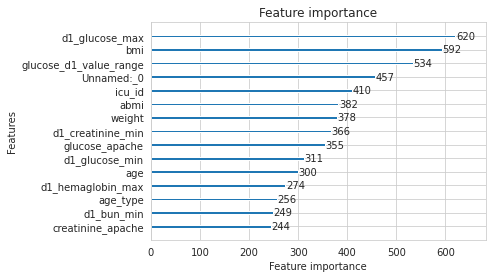

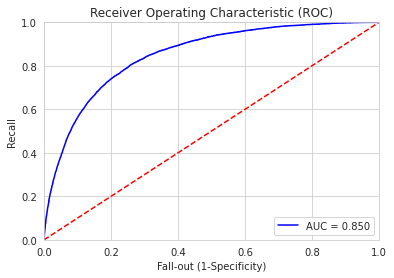

AUC score: 0.8499203514378391


<Figure size 432x288 with 0 Axes>

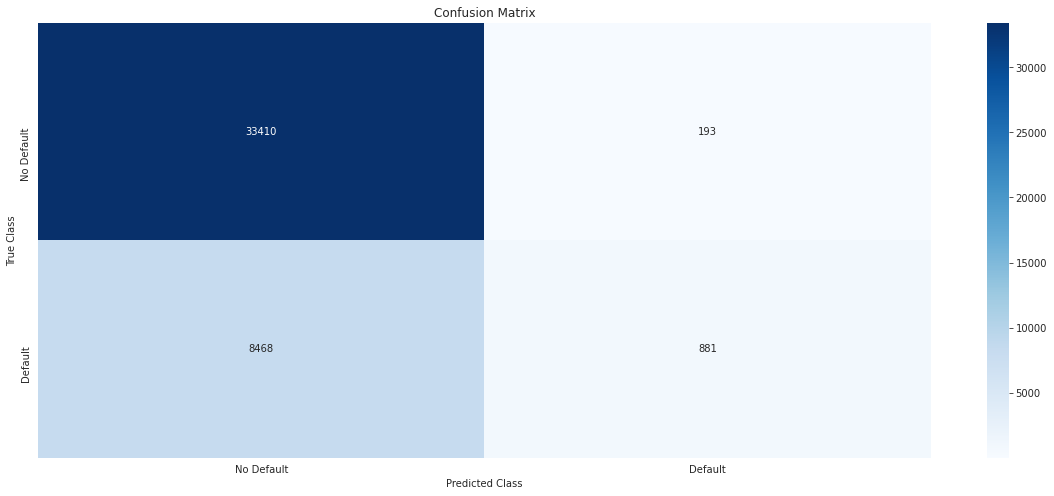

In [ ]:
#predictions_lgbm_prob = lgbm.predict(test_x)
#predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output
pred_lgbm_01 = np.where(pred > 0.5, 1, 0)

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(model, max_num_features=15, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(y_test,pred_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, pred_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(20,8))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# XGB Model 

In [ ]:
xgb_clf = XGBClassifier(tree_method ='auto',
              booster = 'gbtree', 
              predictor = 'cpu_predictor', 
              learning_rate =0.2,
              n_estimators=230,
             max_depth=5,
             min_child_weight=0.421,
             gamma=0.1579,
             objective= 'binary:logistic'
             )


In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1579,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=0.421, missing=None, n_estimators=230, n_jobs=1,
              nthread=None, objective='binary:logistic',
              predictor='cpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='auto', verbosity=1)

In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
xgb.plot_importance(xgb_clf, max_num_features=15)
plt.figure(figsize = (16, 12))
plt.show()

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
params = {'tree_method' : 'auto','booster':'gbtree', 'predictor':'cpu_predictor', 'learning_rate':0.2,'min_child_weight':0.421, 'n_estimators':230,
                    'objective':'binary:logistic','max_depth': 5, 'gamma':0.1579 }  #From grid search, the best parameters

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

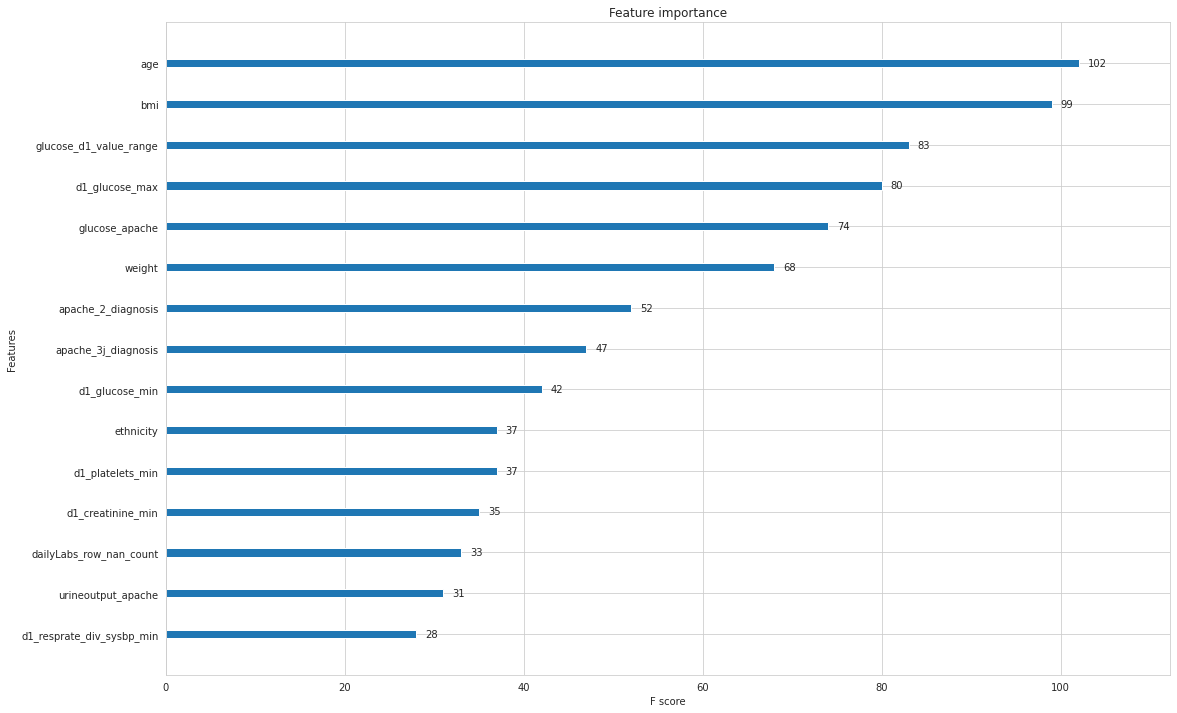

In [ ]:
from pylab import rcParams
plt.rcParams['figure.figsize'] = [18, 12]
xgb.plot_importance(xg_reg, max_num_features=15)

plt.show()

Overall accuracy of XGBoost model: 0.8278077854349041


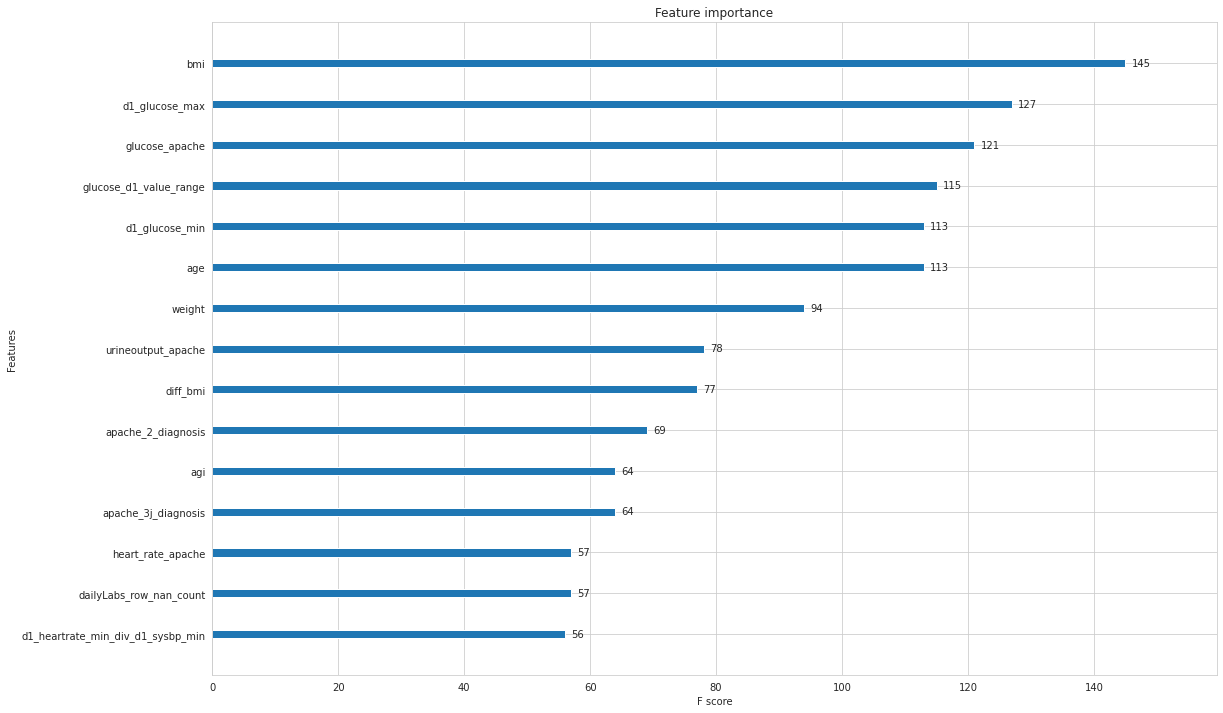

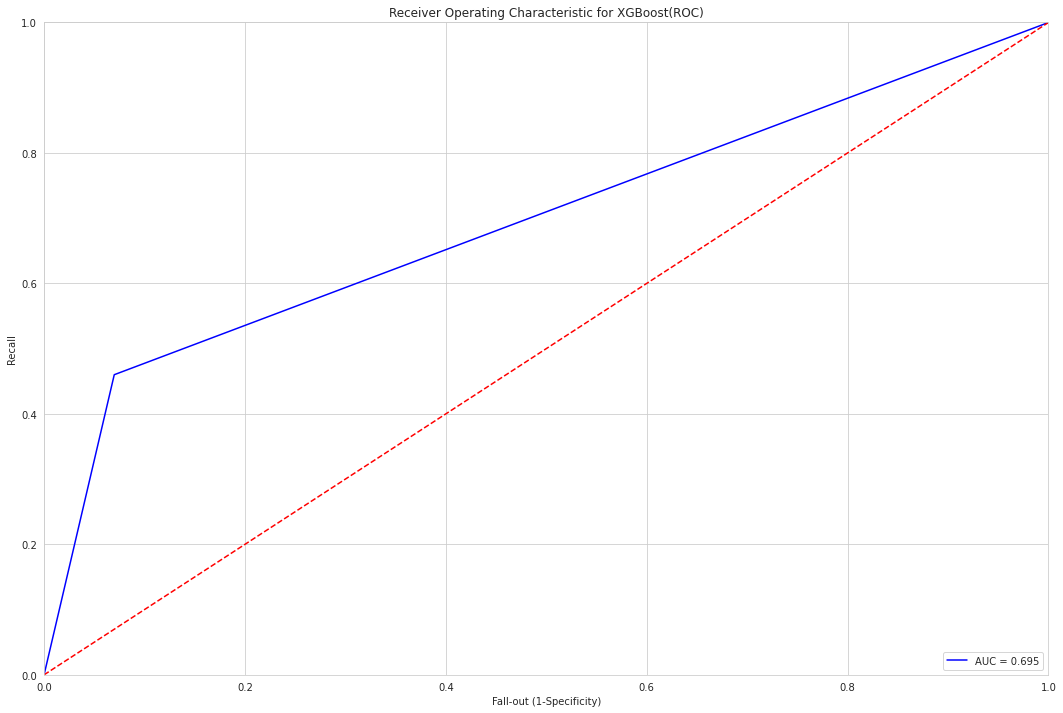

AUC score: 0.6950872447780438


<Figure size 1296x864 with 0 Axes>

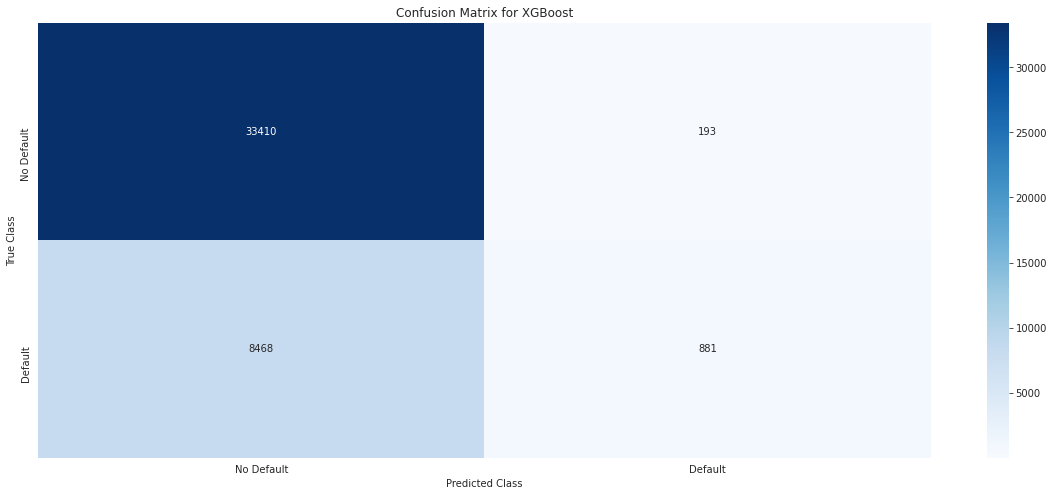

In [ ]:
pred_xgb_01 = np.where(y_pred > 0.5, 1, 0)

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
xgb.plot_importance(xgb_clf, max_num_features=15)

#Print accuracy
acc_xgb = accuracy_score(y_test,pred_xgb_01)
print('Overall accuracy of XGBoost model:', acc_xgb)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic for XGBoost(ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm_xgb = confusion_matrix(y_test, pred_xgb_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(20,8))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 8.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491618 sha256=d5d95696b253c19e6e62644d4c9ae976630536ad36e7940358f73c4d21a68aae
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


Feature Importance Computed with SHAP Values
The SHAP package is used to compute feature importance in Xgboost. It is model-agnostic and using the Shapley values from game theory to estimate how much each feature contribute to the prediction.

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

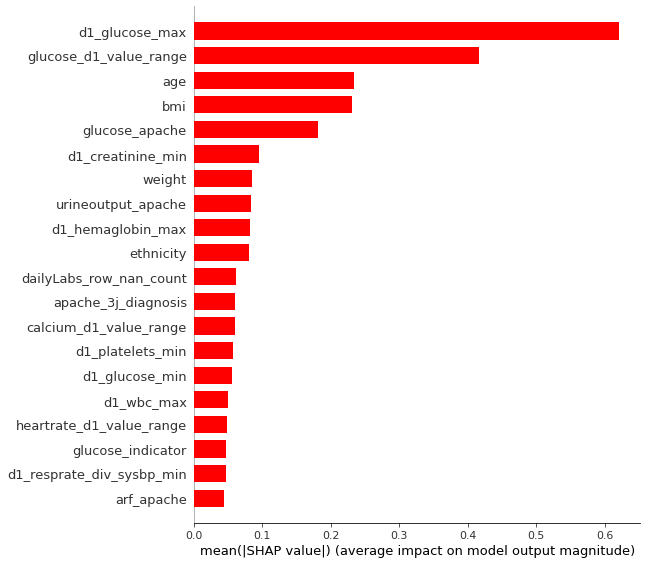

In [ ]:
shap.summary_plot(shap_values, X,color='red', plot_type="bar")

FORCE PLOT: Features each contributing to push the model output from the base value(the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [ ]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

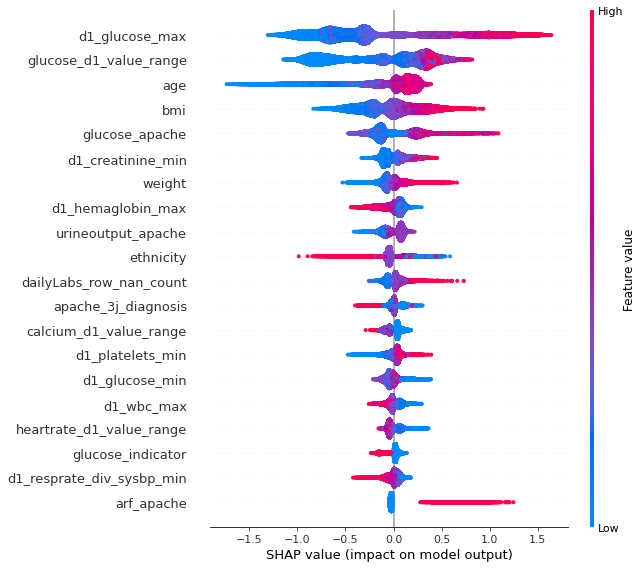

In [ ]:
shap.summary_plot(shap_values, X)

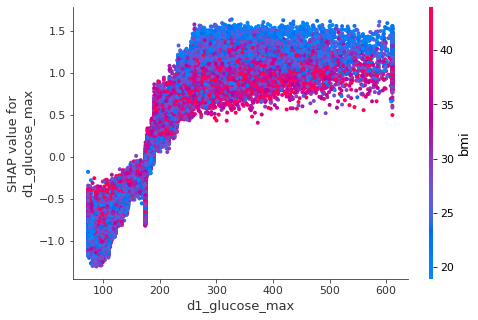

In [ ]:
shap.dependence_plot("d1_glucose_max", shap_values, X, interaction_index="bmi")  #How much interaction terms effect the importance of a feature is capture by the vertical dispersion of the data points. 


For example having a dl_glucose_max of 100 may lower your logg odds of having Diabetes Mellitus(DM) by 1.3 for some patents or only 0.6 for others. Why is this? Because other features of these patients effect how much dl_glucose_max matters for having DM. Note that the vertical spread narrows once you are at about 200 dl_glucose_max, meaning the context of other features matters less for patients with high dl_glucose_max than low dl_glucose_max. We color the datapoints with another feature that most explains the interaction effect variance. For example having less dl_glucose_max is less bad if you have low bmi, but it is bad if you have high bmi.

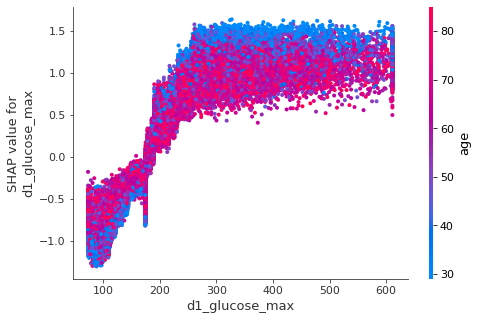

In [ ]:
shap.dependence_plot("d1_glucose_max", shap_values, X, interaction_index="age")